In [4]:
%run regression_code.py
from copy import copy
import warnings
warnings.filterwarnings("ignore")
torch.multiprocessing.set_sharing_strategy('file_system')



# Choose visible device
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Select model number. From 0 to 4, as much as number of folds
MODEL_NUMBER = 0
# Choose experiment

# Z-DNA UMAP

In [3]:
%run regression_code.py
import warnings
warnings.filterwarnings("ignore")



# Choose visible device
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# Select model number. From 0 to 4, as much as number of folds
MODEL_NUMBER = 0
# Choose experiment

In [5]:
ASSEMBLY_d = {}
chroms_d = {}
all_features_d = {}
groups_d = {}
feature_names_d = {}
ZDNA_d = {}
black_list_d = {}
DNA_d = {}
DNA_features_d = {}

In [6]:
ASSEMBLY = "curax_14h_UNI_mm9"
chroms = [f'chr{i}' for i in list(range(1, 20)) + ['X', 'Y']]
all_features = sorted([i[:-4] for i in os.listdir('../data/mm9_features/sparse/') if i.endswith('.pkl')])
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features if (i.split('_')[0] in groups)]
ZDNA = load(f'../data/mm9_zdna/sparse/{ASSEMBLY}.pkl')
black_list = load(f'../data/mm9_zdna/sparse/blacklist_mm9.pkl')


In [7]:
DNA = {chrom:load(f'../data/mm9_dna/sparse/{chrom}.pkl') for chrom in tqdm(chroms)}

DNA_features = {feture: load(f'../data/mm9_features/sparse/{feture}.pkl')
                for feture in tqdm(feature_names)}

for feature in tqdm(DNA_features):
    if set(DNA_features[feature].keys()) != set(chroms):
        for chrom in chroms:
            if chrom not in DNA_features[feature]:
                DNA_features[feature][chrom] = SparseVector(len(DNA[chrom]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 873/873 [00:00<00:00, 433123.66it/s]


In [8]:
mode = 'mm9'
ASSEMBLY_d[mode] = ASSEMBLY
chroms_d[mode] = chroms
all_features_d[mode] = all_features
groups_d[mode] = groups
feature_names_d[mode] = feature_names
ZDNA_d[mode] = ZDNA
black_list_d[mode] = black_list
DNA_d[mode] = DNA
DNA_features_d[mode] = DNA_features

In [9]:
ASSEMBLY = "ZDNA_2016"
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
all_features = sorted([i[:-4] for i in os.listdir('../data/hg19_features/sparse/') if i.endswith('.pkl')])
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features if (i.split('_')[0] in groups)]
ZDNA = load(f'../data/hg19_zdna/sparse/{ASSEMBLY}.pkl')
black_list = load(f'../data/hg19_zdna/sparse/blacklist_hg19.pkl')


In [10]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'../data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"../data/hg19_dna/{file}") for file in files])


DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}

DNA_features = {feture: load(f'../data/hg19_features/sparse/{feture}.pkl')
                for feture in tqdm(feature_names)}

for feature in tqdm(DNA_features):
    if set(DNA_features[feature].keys()) != set(chroms):
        for chrom in chroms:
            if chrom not in DNA_features[feature]:
                DNA_features[feature][chrom] = SparseVector(len(DNA[chrom]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1054/1054 [00:00<00:00, 148828.32it/s]


In [11]:
mode = 'hg19'
ASSEMBLY_d[mode] = ASSEMBLY
chroms_d[mode] = chroms
all_features_d[mode] = all_features
groups_d[mode] = groups
feature_names_d[mode] = feature_names
ZDNA_d[mode] = ZDNA
black_list_d[mode] = black_list
DNA_d[mode] = DNA
DNA_features_d[mode] = DNA_features

In [12]:
intersect = {i.upper() for i in DNA_features_d['mm9']} & {i.upper() for i in DNA_features_d['hg19']}

In [13]:
mode = 'hg19'
ASSEMBLY = ASSEMBLY_d[mode]
chroms = chroms_d[mode]
all_features = all_features_d[mode]
groups = groups_d[mode]
feature_names = feature_names_d[mode]
ZDNA = ZDNA_d[mode]
black_list = black_list_d[mode]
DNA = DNA_d[mode]
DNA_features = DNA_features_d[mode]

In [21]:
deepz_df = pd.read_csv('regions/gen_compare_hg19_3.bed', sep='\t', header=None)
kouzine_df = pd.read_csv('regions/Kouzine_hg19_zdna.bed', sep='\t', header=None)
zdnabert_df = pd.read_csv('regions/HG__thr_0.25_minlen_12_pad.bed', sep='\t', header=None)
exp_df = pd.read_csv('regions/hg19_zdna.bed', sep='\t', header=None)

cra_deepz_df = pd.read_csv('regions/deepZ_3_cons_in_cramer_hg19.bed', sep='\t', header=None)[[0, 1, 2]]
cra_bert_df = pd.read_csv('regions/BERT_cons_in_cramer_hg19.bed', sep='\t', header=None)[[0, 1, 2]]

In [22]:
z_dna_inters = np.concatenate((deepz_df.values, kouzine_df.values, 
                               zdnabert_df.values, exp_df.values,
                               cra_deepz_df.values, cra_bert_df.values
                              ))
z_dna_source = ([f'deepz_{mode}'] * deepz_df.shape[0] + 
                [f'kouzine_{mode}'] * kouzine_df.shape[0] + 
                [f'zdnabert_{mode}'] * zdnabert_df.shape[0]+ 
                [f'zda_{mode}'] * exp_df.shape[0] +
                [f'cra_deepz_{mode}'] * cra_deepz_df.shape[0]+ 
                [f'cra_bert_{mode}'] * cra_bert_df.shape[0])

In [23]:
z_dna_dataset = Dataset(chroms, 
                        [i for i in feature_names if i.upper() in intersect], 
                       DNA, DNA_features, 
                       ZDNA, z_dna_inters)

In [24]:
params = {'batch_size':1,
          'num_workers':64,
          'shuffle':False}

In [25]:
z_dna_train = data.DataLoader(z_dna_dataset, **params)

In [26]:
z_dna_df = []

In [27]:
for source_tag, (X_batch, y_batch) in zip(z_dna_source, tqdm(z_dna_train)):
    z_dna_df.append((source_tag, torch.sum(X_batch[0] > 0, axis=0) + 0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 369370/369371 [03:22<00:00, 1827.23it/s]


In [28]:
mode = 'mm9'
ASSEMBLY = ASSEMBLY_d[mode]
chroms = chroms_d[mode]
all_features = all_features_d[mode]
groups = groups_d[mode]
feature_names = feature_names_d[mode]
ZDNA = ZDNA_d[mode]
black_list = black_list_d[mode]
DNA = DNA_d[mode]
DNA_features = DNA_features_d[mode]

In [358]:
# deepz_df = pd.read_csv('regions/gen_compare_mm9_3.bed', sep='\t', header=None)
deepz_df = pd.read_csv('prediction_new/prediction_mm9_4.bed', sep='\t', header=None)
kouzine_df = pd.read_csv('regions/Kouzine_mm9_zdna.bed', sep='\t', header=None)
zdnabert_df = pd.read_csv('regions/MM__thr_0.5_minlen_10.bed', sep='\t', header=None)
exp_df = pd.read_csv('regions/mm9_zdna.bed', sep='\t', header=None)


In [30]:
z_dna_inters = np.concatenate((deepz_df.values, kouzine_df.values, zdnabert_df.values, exp_df.values))
z_dna_source = ([f'deepz_{mode}'] * deepz_df.shape[0] + 
                [f'kouzine_{mode}'] * kouzine_df.shape[0] + 
                [f'zdnabert_{mode}'] * zdnabert_df.shape[0]+ 
                [f'zda_{mode}'] * exp_df.shape[0])

In [31]:
z_dna_dataset = Dataset(chroms, 
                        [i for i in feature_names if i.upper() in intersect], 
                       DNA, DNA_features, 
                       ZDNA, z_dna_inters)

In [32]:
params = {'batch_size':1,
          'num_workers':64,
          'shuffle':False}

In [33]:
z_dna_train = data.DataLoader(z_dna_dataset, **params)

In [34]:
for source_tag, (X_batch, y_batch) in zip(z_dna_source, tqdm(z_dna_train)):
    z_dna_df.append((source_tag, torch.sum(X_batch[0] > 0, axis=0) + 0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 343010/343011 [04:02<00:00, 1414.38it/s]


In [66]:
seqs = (["A", "C", "T", "G"] + 
                ['AC', 'AT', 'AG', 'CT', 'CG', 'GT'] +
                ['AAC', 'ACC', 'AAT', 'ATT', 'AAG', 'AGG', 
                 'CCA', 'CAA', 'CCT', 'CTT', 'CCG', 'CGG', 
                 'TTA', 'TAA', 'TTC', 'TCC', 'TTG', 'TGG', 
                 'GGA', 'GAA', 'GGC', 'GCC', 'GGT', 'GTT'] +
                ['AAAC', 'AAAT', 'AAAG', 'CCCA', 'CCCT', 'CCCG',
                 'TTTA', 'TTTC', 'TTTG', 'GGGA', 'GGGC', 'GGGT'] + ["PP"])

features = [f"DNA_{i}" for i in seqs] + list(z_dna_dataset.configs) + z_dna_dataset.features

In [157]:
names = [i[0] for i in z_dna_df]
X = np.array([i[1].numpy() for i in z_dna_df])[:, np.array(features) !=  'TFs and others_Epitope tags']

In [159]:
iiddxx = ['hg' in i for i in names]
X = X[iiddxx]
names = np.array(names)[iiddxx]

In [160]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
import seaborn as sns
import colorcet as cc

In [161]:
palette = sns.color_palette(cc.glasbey, n_colors=25)

In [162]:
embedding_hg = umap.UMAP(n_neighbors=15, metric='euclidean', random_state=1,verbose=True,
                      ).fit_transform(X)

names_hg = names

UMAP(random_state=1, verbose=True)
Tue Feb  6 15:44:32 2024 Construct fuzzy simplicial set
Tue Feb  6 15:44:32 2024 Finding Nearest Neighbors
Tue Feb  6 15:44:32 2024 Building RP forest with 35 trees
Tue Feb  6 15:44:43 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	Stopping threshold met -- exiting after 6 iterations
Tue Feb  6 15:45:13 2024 Finished Nearest Neighbor Search
Tue Feb  6 15:45:14 2024 Construct embedding


Epochs completed:   1%| █▏                                                                                                                 2/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| ████████████▍                                                                                                     22/200 [00:15]

	completed  20  /  200 epochs


Epochs completed:  21%| ███████████████████████▋                                                                                          42/200 [00:31]

	completed  40  /  200 epochs


Epochs completed:  30%| ██████████████████████████████████▍                                                                               61/200 [00:46]

	completed  60  /  200 epochs


Epochs completed:  41%| ██████████████████████████████████████████████▎                                                                   82/200 [01:03]

	completed  80  /  200 epochs


Epochs completed:  51%| █████████████████████████████████████████████████████████                                                        102/200 [01:18]

	completed  100  /  200 epochs


Epochs completed:  61%| ████████████████████████████████████████████████████████████████████▎                                            122/200 [01:34]

	completed  120  /  200 epochs


Epochs completed:  70%| ██████████████████████████████████████████████████████████████████████████████▉                                  141/200 [01:49]

	completed  140  /  200 epochs


Epochs completed:  81%| ██████████████████████████████████████████████████████████████████████████████████████████▋                      162/200 [02:06]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████████████████████████████████████████████████████████████████████████████████████████████████▉           182/200 [02:21]

	completed  180  /  200 epochs


Epochs completed: 100%| ████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 200/200 [02:36]


Tue Feb  6 16:07:44 2024 Finished embedding


In [74]:
embedding_mm = umap.UMAP(n_neighbors=15, metric='euclidean', random_state=1,verbose=True,
                      ).fit_transform(X)

names_mm = names

UMAP(random_state=1, verbose=True)
Tue Feb  6 12:11:45 2024 Construct fuzzy simplicial set
Tue Feb  6 12:11:45 2024 Finding Nearest Neighbors
Tue Feb  6 12:11:45 2024 Building RP forest with 34 trees
Tue Feb  6 12:11:57 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	Stopping threshold met -- exiting after 5 iterations
Tue Feb  6 12:12:23 2024 Finished Nearest Neighbor Search
Tue Feb  6 12:12:27 2024 Construct embedding


Epochs completed:   0%| ▌                                                                                                                  1/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| ████████████▍                                                                                                     22/200 [00:14]

	completed  20  /  200 epochs


Epochs completed:  21%| ███████████████████████▋                                                                                          42/200 [00:29]

	completed  40  /  200 epochs


Epochs completed:  31%| ███████████████████████████████████                                                                               62/200 [00:43]

	completed  60  /  200 epochs


Epochs completed:  41%| ██████████████████████████████████████████████▎                                                                   82/200 [00:58]

	completed  80  /  200 epochs


Epochs completed:  50%| ████████████████████████████████████████████████████████▌                                                        101/200 [01:12]

	completed  100  /  200 epochs


Epochs completed:  61%| ████████████████████████████████████████████████████████████████████▎                                            122/200 [01:27]

	completed  120  /  200 epochs


Epochs completed:  70%| ██████████████████████████████████████████████████████████████████████████████▉                                  141/200 [01:41]

	completed  140  /  200 epochs


Epochs completed:  81%| ██████████████████████████████████████████████████████████████████████████████████████████▋                      162/200 [01:56]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████████████████████████████████████████████████████████████████████████████████████████████████▉           182/200 [02:11]

	completed  180  /  200 epochs


Epochs completed: 100%| ████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 200/200 [02:24]


Tue Feb  6 12:24:45 2024 Finished embedding


In [349]:


color_pallete = {
    'zda_hg19': "brown",
    'deepz_hg19': 'orange',
    
    'kouzine_hg19': palette[10],
    'zdnabert_hg19': palette[3],
    'cra_deepz_hg19':'magenta',
    'cra_bert_hg19' : 'magenta'
}

alpha_pallete = {
    'zda_hg19': 0.35,
    'deepz_hg19': 0.15,
    'kouzine_hg19': 0.04,
    'zdnabert_hg19': 0.01,
    'cra_deepz_hg19':0.35,
    'cra_bert_hg19':0.25
    
}

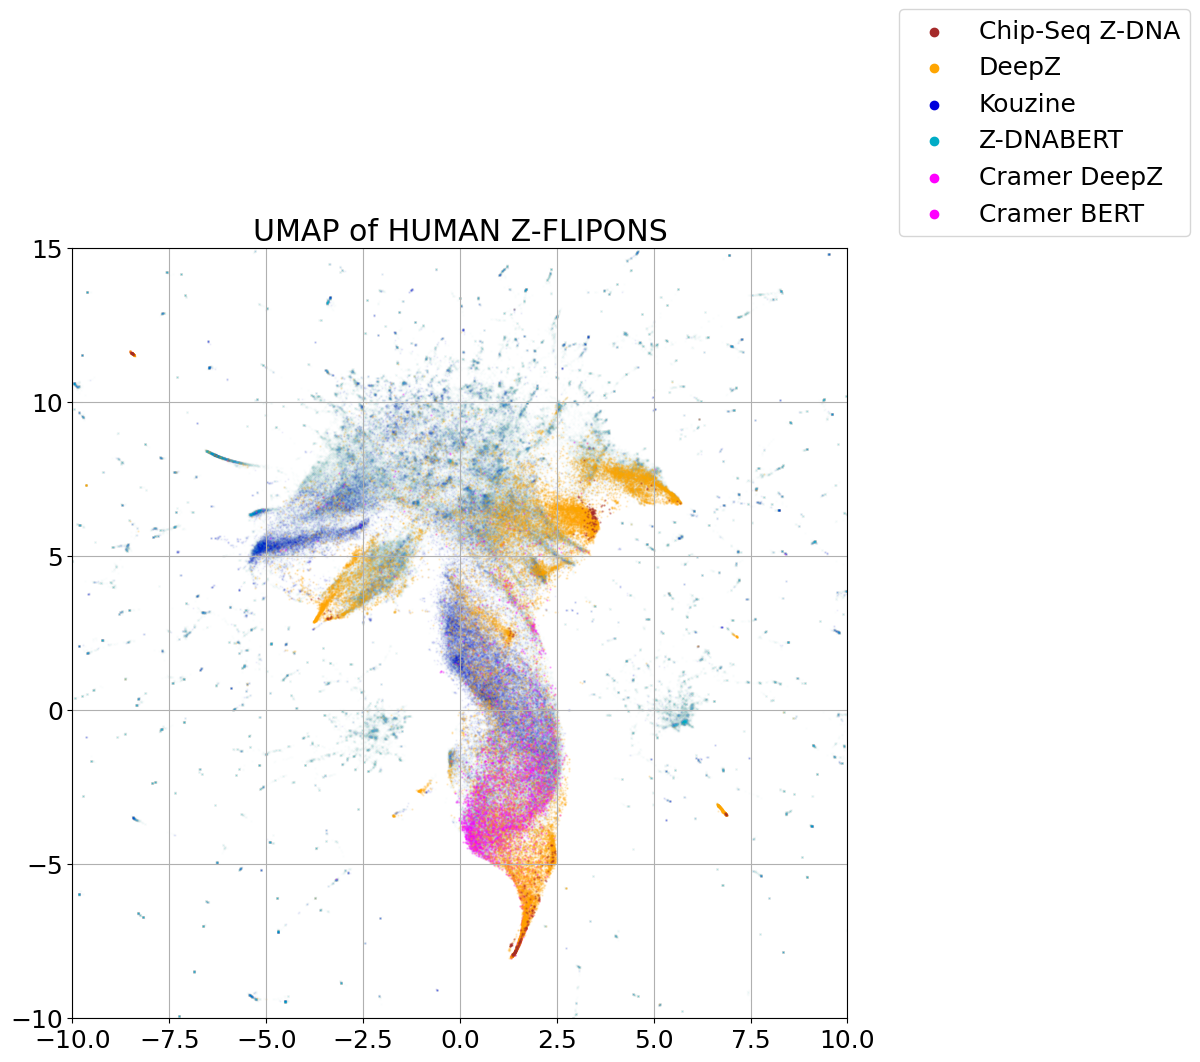

In [351]:
embedding = embedding_hg
names = names_hg


bias = 0
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 10))
for j, group in enumerate(['zdnabert_hg19',
                            'kouzine_hg19',
                            'cra_bert_hg19',
                            'cra_deepz_hg19',
                            'deepz_hg19',
                            'zda_hg19',
]):
    
    indd = [i == group for i in names]
    plt.scatter(embedding[indd, 0], 
                embedding[indd, 1], alpha=alpha_pallete[group],
                s=0.5, color=color_pallete[group])
plt.scatter([], [], label='Chip-Seq Z-DNA', color=color_pallete['zda_hg19'])
plt.scatter([], [], label='DeepZ', color=color_pallete['deepz_hg19'])
plt.scatter([], [], label='Kouzine', color=color_pallete['kouzine_hg19'])
plt.scatter([], [], label='Z-DNABERT', color=color_pallete['zdnabert_hg19'])
plt.scatter([], [], label='Cramer DeepZ', color=color_pallete['cra_deepz_hg19'])
plt.scatter([], [], label='Cramer BERT', color=color_pallete['cra_bert_hg19'])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.title('UMAP of HUMAN Z-FLIPONS')
plt.xlim(-10, 10)
plt.ylim(-10, 15)
plt.savefig('tmp/UMAP_hg.jpg', bbox_inches = 'tight', dpi=400)
plt.show()